**# SERIES DE TIEMPO MULTIVARIADAS PARA PRONOSTICAR EL NÚMERO DE SUICIDIOS POR CADA 100 MIL HABITANTES EN PAÍSES DE LATINOAMÉRICA.**






## Carga de ibrerias

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
from tensorflow import keras as ks
from keras.layers import GRU
from tensorflow.estimator import LinearRegressor
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing

print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


2.2.0


In [ ]:
from tensorflow.estimator import LinearRegressor
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing

## Carga de base de datos

In [ ]:
#suicides_load=pd.read_csv('C:/Users/Viviana/Desktop/Materias/Mineria/master.csv')
suicides_load=pd.read_csv('/content/master1.csv')

## Variables dummy

In [ ]:
dummie_sex=pd.get_dummies(suicides_load.sex)
dummie_age=pd.get_dummies(suicides_load.age)
#dummie_generation=pd.get_dummies(suicides_load.generation)

## Columnas de la base original junto con las columnas de las variables dummy

In [ ]:
#suicides_data=pd.concat([suicides_load,dummie_sex,dummie_age,dummie_generation],axis='columns')
suicides_data=pd.concat([suicides_load,dummie_sex,dummie_age],axis='columns')
#suicides_data=suicides_data.drop(['sex','age','generation','HDI for year'],axis='columns')
suicides_data=suicides_data.drop(['sex','age','generation','HDI for year','gdp_for_year',],axis='columns')
suicides_data.head(3)

,country,year,suicides_no,population,suicides/100k pop,country-year,gdp_per_capita,female,male,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
0,Albania,1987,21,312900.0,6.71,Albania1987,796,0,1,1,0,0,0,0,0
1,Albania,1987,16,308000.0,5.19,Albania1987,796,0,1,0,0,1,0,0,0
2,Albania,1987,14,289700.0,4.83,Albania1987,796,1,0,1,0,0,0,0,0


**GDP:** Son las siglas en inglés (Gross Domestic Product) del Producto Interno Bruto o PIB que describe el valor monetario de la producción de servicios y bienes de demanda final en un país, en este caso, **anualmente**.

**GDP Per Capita:** Es la división del Producto Interno Bruto de cada país dividido entre el número total de habitantes.

Se usan para mostrar las diferencias económicas entre países.


## Arreglo de la base de datos

In [ ]:
suicides_dummys=suicides_data.iloc[:,7:16].mul(suicides_data['suicides_no'], axis=0)
suicides_data2=pd.concat([suicides_data.iloc[:,0:7],suicides_dummys], axis='columns')
data=suicides_data2.groupby(['country','year','country-year', 'gdp_per_capita']).sum()
data['suicides/100k pop']=100000*(data['suicides_no']/data['population'])
data=data.reset_index()
data=data.set_index('year')
data=data.drop(['country-year'],axis='columns')
data.head(5)

,country,gdp_per_capita,suicides_no,population,suicides/100k pop,female,male,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
year,,,,,,,,,,,,,
1987,Albania,796,73,2709600.0,2.694125,25,48,35,13,22,0,1,2
1988,Albania,769,63,2764300.0,2.279058,22,41,25,10,18,0,7,3
1989,Albania,833,68,2803100.0,2.425886,15,53,17,20,22,0,7,2
1992,Albania,251,47,2822500.0,1.665190,14,33,16,11,14,0,6,0
1993,Albania,437,73,2807300.0,2.600363,27,46,28,16,17,2,9,1


# **GUATEMALA**


In [ ]:
Guatemala_suicides=data[data.country=="Guatemala"]
Guatemala_suicides=Guatemala_suicides.drop(['country'],axis='columns')
Guatemala_suicides.shape
Guatemala_suicides.tail(5)

,gdp_per_capita,suicides_no,population,suicides/100k pop,female,male,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
year,,,,,,,,,,,,
2011,3661,359,13017342.0,2.757859,108,251,164,81,63,17,28,6
2012,3779,420,13335425.0,3.149506,110,310,181,81,89,21,39,9
2013,3947,455,13641878.0,3.335318,124,331,197,105,95,18,34,6
2014,4210,512,13947190.0,3.670990,156,356,201,119,119,19,47,7
2015,4472,494,14258397.0,3.464625,144,350,208,105,107,24,38,12


## Gráfico de serie de interes (suicides/100k pop) y de coseries

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


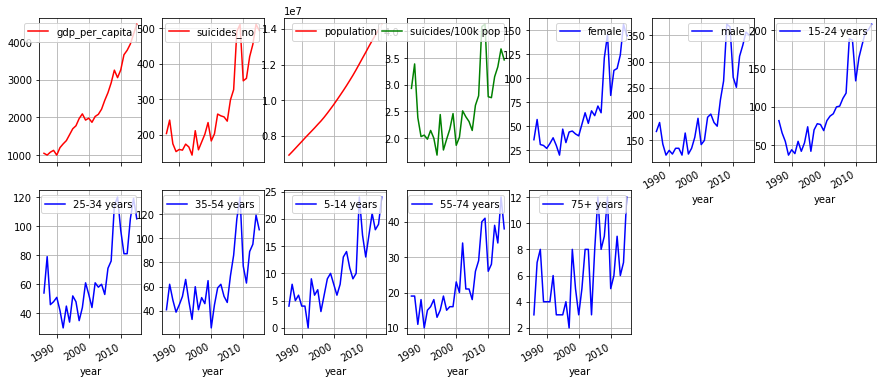

In [ ]:
features=Guatemala_suicides
features.plot(kind='line', figsize=(15,10), subplots=True, grid=True,
    layout=(3, 7), sharex=True, sharey=False, legend=False,    
    style=['r', 'r', 'r', 'g', 'b', 'b', 'b', 'b', 'b', 'b', 'b','b','b','b','b','b','b','b'])
[ax.legend(loc=1) for ax in plt.gcf().axes]

plt.show()

## Selección de tamaño de muestra de entrenamiento y validación


In [ ]:
train_set=features.iloc[:25, :]
#train_set.shape
test_set=features.iloc[25:30,:]
test_set.shape
#train_set.shape[0]

(5, 12)

## Estandarización de datos

In [ ]:
TRAIN_SPLIT=train_set.shape[0]
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

## Función Ventana de entrenamiento.

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

## Selección de muestra de entrenamiento y validación para modelo multivariado

In [ ]:
past_history = 4 #se usan los últimos 5 datos para predecir a un paso.
future_target = 0 
STEP = 1
x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 3], 0,  #la columna 4 es 'suicides/100k pop'
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 3],
                                               TRAIN_SPLIT, 30, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [ ]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (4, 12)


## Convertir datos en tensores

In [ ]:
BATCH_SIZE=2 # 2 Lotes de 13 y 12 filas o registros 
BUFFER_SIZE=1000
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

## MODELO DE RED LSTM

In [ ]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(70,input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
single_step_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 70)                23240     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 71        
Total params: 23,311
Trainable params: 23,311
Non-trainable params: 0
_________________________________________________________________


## Evaluación de función de pérdida

In [ ]:
EPOCHS=10
EVALUATION_INTERVAL=1
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=1)

Epoch 1/10
1/1 [==============================] - 0s 12ms/step - loss: 0.1657 - val_loss: 0.5666
Epoch 2/10
1/1 [==============================] - 0s 11ms/step - loss: 0.2548 - val_loss: 0.5196
Epoch 3/10
1/1 [==============================] - 0s 11ms/step - loss: 0.1061 - val_loss: 0.4186
Epoch 4/10
1/1 [==============================] - 0s 12ms/step - loss: 0.0496 - val_loss: 0.3410
Epoch 5/10
1/1 [==============================] - 0s 11ms/step - loss: 0.2451 - val_loss: 0.0847
Epoch 6/10
1/1 [==============================] - 0s 10ms/step - loss: 0.1213 - val_loss: 0.0449
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.1115 - val_loss: 0.0286
Epoch 8/10
1/1 [==============================] - 0s 10ms/step - loss: 0.2962 - val_loss: 0.1047
Epoch 9/10
1/1 [==============================] - 0s 13ms/step - loss: 0.0591 - val_loss: 0.0071
Epoch 10/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0361 - val_loss: 0.1295


## Función para gráficar pérdida

In [ ]:
#### FUNCIÓN PARA GRAFICAR EL ENTRENAMIENTO DE UN PASO Y FUNCIÓN DE PÉRDIDA
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

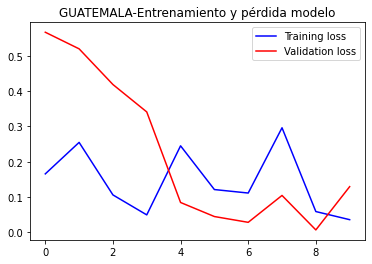

In [ ]:
plot_train_history(single_step_history,
                   'GUATEMALA-Entrenamiento y pérdida modelo')

In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))

In [ ]:
#### FUNCIÓN PARA GRAFICAR DATOS HISTÓRICOS Y PREDICCIÓN
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

## PREDICCIÓN A UN PASO 

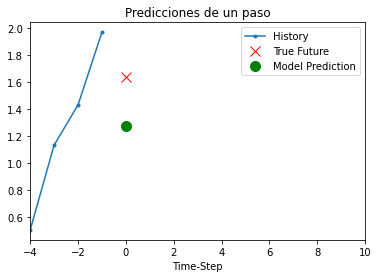

In [ ]:
for x, y in val_data_single.take(1):
  plot = show_plot([x[0][:, 3].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 0,
                   'Predicciones de un paso')
  plot.show()

## Graficar serie con dato predicho

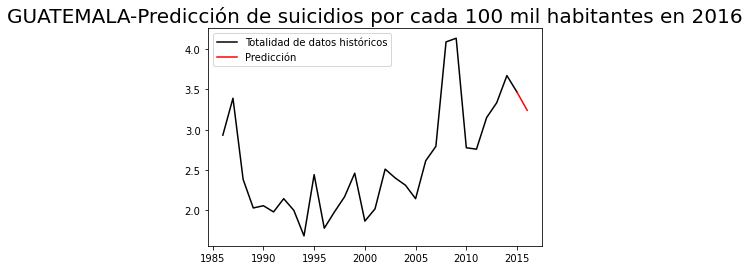

array([3.2401924], dtype=float32)

In [ ]:
NGU=len(Guatemala_suicides.index)-1
new_indexGU=np.append(Guatemala_suicides.index, Guatemala_suicides.index[NGU]+1)
new_predGU=(single_step_model.predict(x)[0])*data_std[3]+data_mean[3]
new_suicides_rateGU=np.append(Guatemala_suicides['suicides/100k pop'],new_predGU)
new_dataGU=pd.DataFrame({'new_suicides_rate':new_suicides_rateGU},index=new_indexGU)
plt.plot(new_dataGU[:NGU+1], color='black', label='Totalidad de datos históricos')
plt.plot(new_dataGU[NGU:],label='Predicción',color='r')
plt.title("GUATEMALA-Predicción de suicidios por cada 100 mil habitantes en 2016", size = 20)
plt.scatter(2016, 2.7, s=30, c='black')
plt.legend()
plt.show()
new_predGU

# BRASIL

In [ ]:
brazil_suicides=data[data.country=="Brazil"]
brazil_suicides=brazil_suicides.drop(['country'],axis='columns')
brazil_suicides=brazil_suicides.drop([1985],axis=0)
brazil_suicides.shape
brazil_suicides.head(2)

,gdp_per_capita,suicides_no,population,suicides/100k pop,female,male,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
year,,,,,,,,,,,,
1986,2257,4271,118776400.0,3.595832,1154,3117,1016,1011,1302,62,744,136
1987,2394,4672,122822467.0,3.803864,1163,3509,1004,1131,1449,67,844,177


## Gráfico de serie de interes (suicides/100k pop) y de coseries

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


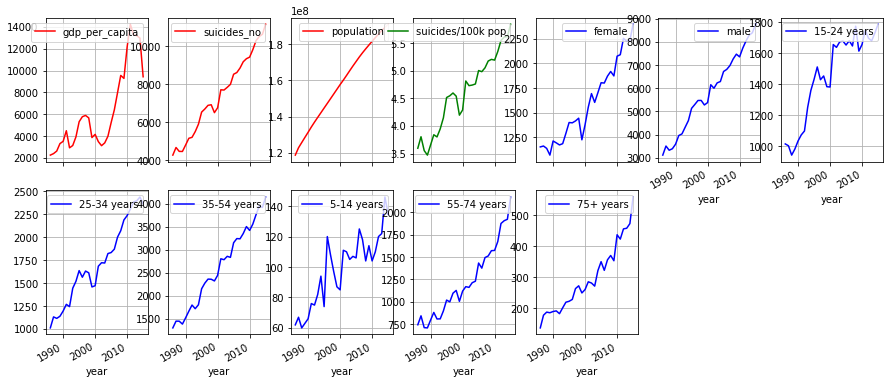

In [ ]:
featuresB=brazil_suicides
featuresB.plot(kind='line', figsize=(15,10), subplots=True, grid=True,
    layout=(3, 7), sharex=True, sharey=False, legend=False,    
    style=['r', 'r', 'r', 'g', 'b', 'b', 'b', 'b', 'b', 'b', 'b','b','b','b','b','b','b','b'])
[ax.legend(loc=1) for ax in plt.gcf().axes]
plt.show()

## Selección de tamaño de muestra de entrenamiento y validación

In [ ]:
featuresB=brazil_suicides
train_setB=featuresB.iloc[:25, :]
test_setB=featuresB.iloc[25:30,:]
test_setB.shape

(5, 12)

## Estandarización de datos

In [ ]:
TRAIN_SPLITB=train_setB.shape[0]
datasetB = featuresB.values
data_meanB = datasetB[:TRAIN_SPLITB].mean(axis=0)
data_stdB = datasetB[:TRAIN_SPLITB].std(axis=0)
datasetB = (datasetB-data_meanB)/data_stdB

## Selección de ventana de entrenamiento y validación para modelo multivariado

In [ ]:
past_history = 4 #se usan los últimos 4 datos para predecir a un paso.
future_target = 0 
STEP = 1
x_train_singleB, y_train_singleB = multivariate_data(datasetB, datasetB[:, 3], 0,  #la columna 3 es 'suicides/100k pop'
                                                   TRAIN_SPLITB, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_singleB, y_val_singleB = multivariate_data(datasetB, datasetB[:, 3],
                                               TRAIN_SPLITB, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

## Convertir datos en tensores

In [ ]:
BATCH_SIZE=2 
BUFFER_SIZE=1000

train_data_singleB = tf.data.Dataset.from_tensor_slices((x_train_singleB, y_train_singleB))
train_data_singleB = train_data_singleB.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_singleB = tf.data.Dataset.from_tensor_slices((x_val_singleB, y_val_singleB))
val_data_singleB = val_data_singleB.batch(BATCH_SIZE).repeat()

## MODELO DE RED LSTM

In [ ]:
single_step_modelB = tf.keras.models.Sequential()
single_step_modelB.add(tf.keras.layers.LSTM(70,input_shape=x_train_singleB.shape[-2:]))
#single_step_modelB.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,input_shape=x_train_singleB.shape[-2:])))
single_step_modelB.add(tf.keras.layers.Dense(1))
single_step_modelB.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
single_step_modelB.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 70)                23240     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 71        
Total params: 23,311
Trainable params: 23,311
Non-trainable params: 0
_________________________________________________________________


## Evaluación de función de pérdida

In [ ]:
EPOCHS=10
EVALUATION_INTERVAL=1
single_step_historyB = single_step_modelB.fit(train_data_singleB, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_singleB,
                                            validation_steps=1)

Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.3407 - val_loss: 0.8271
Epoch 2/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0278 - val_loss: 0.9971
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.1988 - val_loss: 1.0427
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.3751 - val_loss: 0.6578
Epoch 5/10
1/1 [==============================] - 0s 10ms/step - loss: 0.1695 - val_loss: 0.3477
Epoch 6/10
1/1 [==============================] - 0s 10ms/step - loss: 0.6439 - val_loss: 0.3864
Epoch 7/10
1/1 [==============================] - 0s 10ms/step - loss: 0.2983 - val_loss: 0.3669
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.1391 - val_loss: 0.3824
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.2713 - val_loss: 0.6197
Epoch 10/10
1/1 [==============================] - 0s 8ms/step - loss: 0.1014 - val_loss: 0.2559


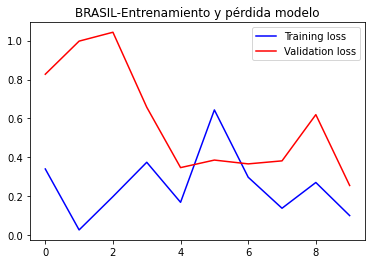

In [ ]:
plot_train_history(single_step_historyB,
                   'BRASIL-Entrenamiento y pérdida modelo')

## Obtención de la predicción a un paso

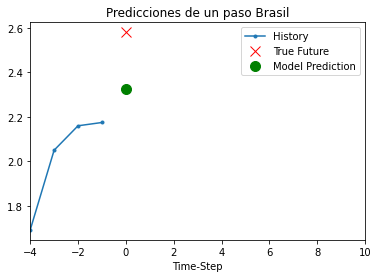

In [ ]:
for x, y in val_data_singleB.take(1):
  plot = show_plot([x[0][:, 3].numpy(), y[0].numpy(),
                    single_step_modelB.predict(x)[0]], 0,
                   'Predicciones de un paso Brasil')
  plot.show()

## Graficar serie con dato predicho

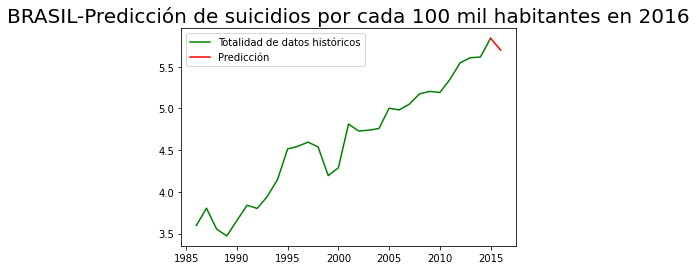

array([5.699365], dtype=float32)

In [ ]:
NBR=len(brazil_suicides.index)-1
new_indexBR=np.append(brazil_suicides.index, brazil_suicides.index[NBR]+1)
new_predBR=(single_step_modelB.predict(x)[0])*data_stdB[3]+data_meanB[3]
new_suicides_rateBR=np.append(brazil_suicides['suicides/100k pop'],new_predBR)
new_dataBR=pd.DataFrame({'new_suicides_rate':new_suicides_rateBR},index=new_indexBR)
plt.plot(new_dataBR[:NBR+1], color='g', label='Totalidad de datos históricos')
plt.plot(new_dataBR[NBR:],label='Predicción',color='r')
plt.title("BRASIL-Predicción de suicidios por cada 100 mil habitantes en 2016", size = 20)
plt.legend()
plt.show()
new_predBR

## MODELO DE RED GRU

In [ ]:
model_gru = tf.keras.models.Sequential()
model_gru.add(tf.keras.layers.GRU(70,input_shape=x_train_singleB.shape[-2:]))
model_gru.add(tf.keras.layers.Dense(1))
model_gru.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
model_gru.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 70)                17640     
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 71        
Total params: 17,711
Trainable params: 17,711
Non-trainable params: 0
_________________________________________________________________


In [ ]:
EPOCHS=10
EVALUATION_INTERVAL=1
single_step_historyBgru = model_gru.fit(train_data_singleB, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_singleB,
                                        validation_steps=1)

Epoch 1/10
1/1 [==============================] - 0s 12ms/step - loss: 0.2349 - val_loss: 1.1856
Epoch 2/10
1/1 [==============================] - 0s 10ms/step - loss: 0.4141 - val_loss: 1.1108
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.1087 - val_loss: 0.7420
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.1143 - val_loss: 1.0555
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0676 - val_loss: 0.6592
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.5260 - val_loss: 0.6822
Epoch 7/10
1/1 [==============================] - 0s 7ms/step - loss: 0.1862 - val_loss: 0.9380
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.4011 - val_loss: 1.1256
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.4662 - val_loss: 1.2546
Epoch 10/10
1/1 [==============================] - 0s 8ms/step - loss: 0.2548 - val_loss: 0.7275


## Evaluación función de pérdida con Red GRU

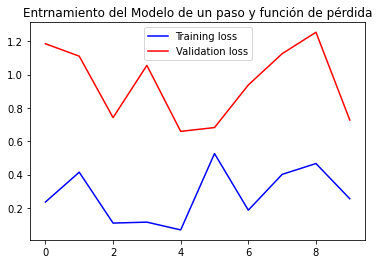

In [ ]:
plot_train_history(single_step_historyBgru,
                   'Entrnamiento del Modelo de un paso y función de pérdida')

## Predicción a un paso con modelo GRU

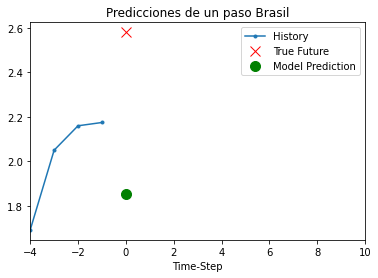

In [ ]:
for x, y in val_data_singleB.take(1):
  plot = show_plot([x[0][:, 3].numpy(), y[0].numpy(),
                    model_gru.predict(x)[0]], 0,
                   'Predicciones de un paso Brasil')
  plot.show()

Dado que se tuvieron mejores resultados con la modelo LSTM unidireccional, se seguirá trabajando con este.

#CHILE

In [ ]:
chile_suicides=data[data.country=="Chile"]
chile_suicides=chile_suicides.drop(['country'],axis='columns')
chile_suicides=chile_suicides.drop([1985],axis=0)
chile_suicides.shape
chile_suicides.head(2)

,gdp_per_capita,suicides_no,population,suicides/100k pop,female,male,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
year,,,,,,,,,,,,
1986,1728,654,10931700.0,5.982601,122,532,145,150,193,11,131,24
1987,1985,693,11209000.0,6.182532,125,568,154,176,194,7,143,19


## Gráfico de serie de estudio (suicides/100k pop) y de coseries

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


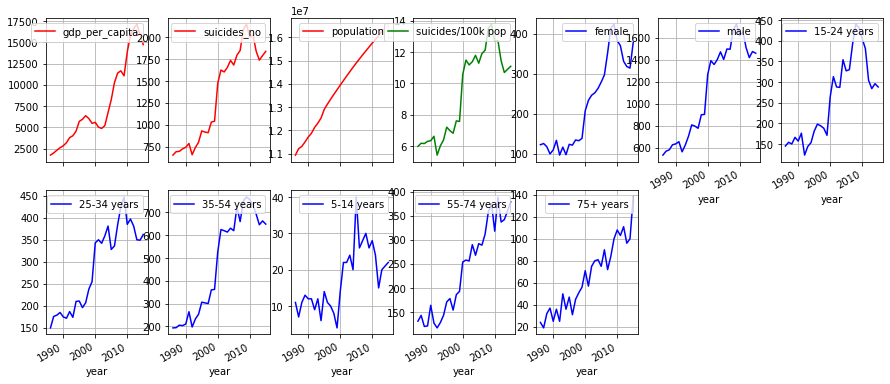

In [ ]:
featuresCH=chile_suicides
featuresCH.plot(kind='line', figsize=(15,10), subplots=True, grid=True,
    layout=(3, 7), sharex=True, sharey=False, legend=False,    
    style=['r', 'r', 'r', 'g', 'b', 'b', 'b', 'b', 'b', 'b', 'b','b','b','b','b','b','b','b'])
[ax.legend(loc=1) for ax in plt.gcf().axes]
plt.show()

## Selección de tamaño de muestra de entrenamiento y validación

In [ ]:
featuresCH=chile_suicides
train_setCH=featuresCH.iloc[:25, :]
test_setCH=featuresCH.iloc[25:30,:]
test_setCH.shape

(5, 12)

## Estandarización de datos

In [ ]:
TRAIN_SPLITCH=train_setCH.shape[0]
datasetCH = featuresCH.values
data_meanCH = datasetCH[:TRAIN_SPLITCH].mean(axis=0)
data_stdCH = datasetCH[:TRAIN_SPLITCH].std(axis=0)
datasetCH = (datasetCH-data_meanCH)/data_stdCH

## Selección de ventana de entrenamiento y validación para modelo multivariado

In [ ]:
past_history = 4 #se usan los últimos 4 datos para predecir a un paso.
future_target = 0 
STEP = 1
x_train_singleCH, y_train_singleCH = multivariate_data(datasetCH, datasetCH[:, 3], 0,  #la columna 3 es 'suicides/100k pop'
                                                   TRAIN_SPLITCH, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_singleCH, y_val_singleCH = multivariate_data(datasetCH, datasetCH[:, 3],
                                               TRAIN_SPLITCH, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

## Convertir datos en tensores

In [ ]:
BATCH_SIZE=2
BUFFER_SIZE=1000

train_data_singleCH = tf.data.Dataset.from_tensor_slices((x_train_singleCH, y_train_singleCH))
train_data_singleCH = train_data_singleCH.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_singleCH = tf.data.Dataset.from_tensor_slices((x_val_singleCH, y_val_singleCH))
val_data_singleCH = val_data_singleCH.batch(BATCH_SIZE).repeat()

## MODELO DE RED LSTM

In [ ]:
single_step_modelCH = tf.keras.models.Sequential()
single_step_modelCH.add(tf.keras.layers.LSTM(70,input_shape=x_train_singleCH.shape[-2:]))
single_step_modelCH.add(tf.keras.layers.Dense(1))
single_step_modelCH.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

## Evaluación de función de pérdida

In [ ]:
EPOCHS=10
EVALUATION_INTERVAL=1
single_step_historyCH = single_step_modelCH.fit(train_data_singleCH, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_singleCH,
                                            validation_steps=1)

Epoch 1/10
1/1 [==============================] - 0s 355ms/step - loss: 1.5000 - val_loss: 0.9609
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.8795 - val_loss: 0.7866
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.8768 - val_loss: 0.6412
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.7619 - val_loss: 0.6584
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.6566 - val_loss: 0.5457
Epoch 6/10
1/1 [==============================] - 0s 12ms/step - loss: 1.3970 - val_loss: 0.1835
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.4623 - val_loss: 0.0799
Epoch 8/10
1/1 [==============================] - 0s 7ms/step - loss: 0.3830 - val_loss: 0.0592
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.4938 - val_loss: 0.1398
Epoch 10/10
1/1 [==============================] - 0s 8ms/step - loss: 0.2139 - val_loss: 0.3292


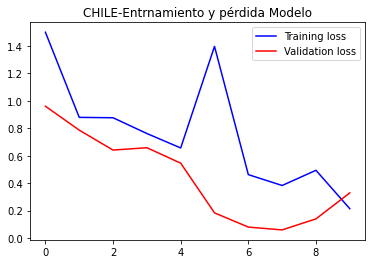

In [ ]:
plot_train_history(single_step_historyCH,
                   'CHILE-Entrnamiento y pérdida Modelo')

## Obtención de la predicción a un paso

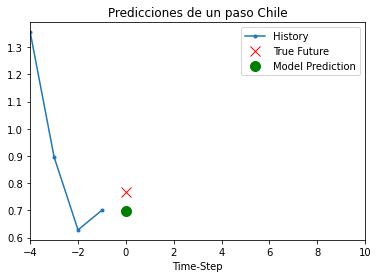

In [ ]:

for x, y in val_data_singleCH.take(1):
  plot = show_plot([x[0][:, 3].numpy(), y[0].numpy(),
                    (single_step_modelCH.predict(x)[0])], 0,
                   'Predicciones de un paso Chile')
  plot.show()

## Graficar serie con dato predicho

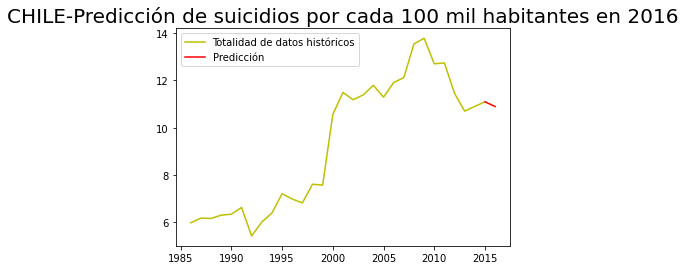

array([10.896438], dtype=float32)

In [ ]:
NCH=len(chile_suicides.index)-1
new_indexCH=np.append(chile_suicides.index, chile_suicides.index[NCH]+1)
new_predCH=(single_step_modelCH.predict(x)[0])*data_stdCH[3]+data_meanCH[3]
new_suicides_rateCH=np.append(chile_suicides['suicides/100k pop'],new_predCH)
new_dataCH=pd.DataFrame({'new_suicides_rate':new_suicides_rateCH},index=new_indexCH)
plt.plot(new_dataCH[:NCH+1], color='y', label='Totalidad de datos históricos')
plt.plot(new_dataCH[NCH:],label='Predicción',color='r')
plt.title("CHILE-Predicción de suicidios por cada 100 mil habitantes en 2016", size = 20)
plt.legend()
plt.show()
new_predCH

# ECUADOR

In [ ]:
ecuador_suicides=data[data.country=="Ecuador"]
ecuador_suicides=ecuador_suicides.drop(['country'],axis='columns')
ecuador_suicides=ecuador_suicides.drop([1985],axis=0)
#ecuador_suicides.shape
ecuador_suicides.head(2)

,gdp_per_capita,suicides_no,population,suicides/100k pop,female,male,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
year,,,,,,,,,,,,
1986,1943,377,7881300.0,4.783475,131,246,161,95,64,12,35,10
1987,1669,390,8356800.0,4.666858,131,259,157,100,89,12,25,7


## Gráfico de serie de interes (suicides/100k pop) y de coseries

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


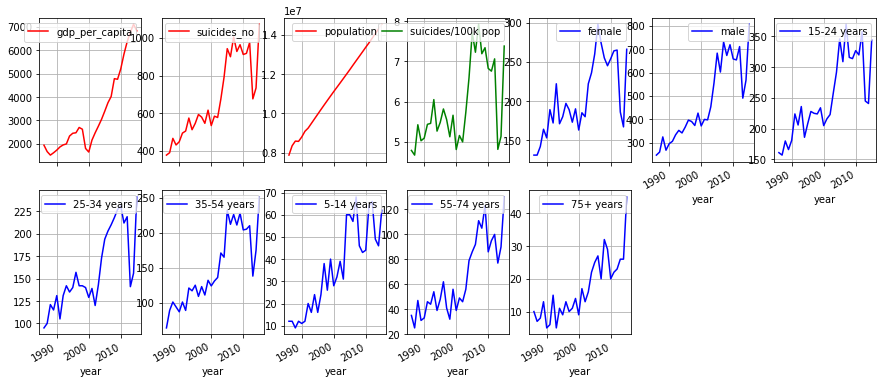

In [ ]:
featuresEC=ecuador_suicides
featuresEC.plot(kind='line', figsize=(15,10), subplots=True, grid=True,
    layout=(3, 7), sharex=True, sharey=False, legend=False,    
    style=['r', 'r', 'r', 'g', 'b', 'b', 'b', 'b', 'b', 'b', 'b','b','b','b','b','b','b','b'])
[ax.legend(loc=1) for ax in plt.gcf().axes]
plt.show()

## Selección de tamaño de muestra de entrenamiento y validación

In [ ]:
featuresEC=ecuador_suicides
train_setEC=featuresEC.iloc[:25, :]
test_setEC=featuresEC.iloc[25:30,:]
test_setEC.shape

(5, 12)

## Estandarización de datos

In [ ]:
TRAIN_SPLITEC=train_setEC.shape[0]
datasetEC = featuresEC.values
data_meanEC = datasetEC[:TRAIN_SPLITEC].mean(axis=0)
data_stdEC = datasetEC[:TRAIN_SPLITEC].std(axis=0)
datasetEC = (datasetEC-data_meanEC)/data_stdEC


## Selección de muestra de entrenamiento y validación para modelo multivariado

In [ ]:
past_history = 4 #se usan los últimos 4 datos para predecir a un paso.
future_target = 0 
STEP = 1
x_train_singleEC, y_train_singleEC = multivariate_data(datasetEC, datasetEC[:, 3], 0,  #la columna 3 es 'suicides/100k pop'
                                                   TRAIN_SPLITEC, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_singleEC, y_val_singleEC = multivariate_data(datasetEC, datasetEC[:, 3],
                                               TRAIN_SPLITEC, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

## Convertir datos en tensores

In [ ]:
BATCH_SIZE=2
BUFFER_SIZE=1000

train_data_singleEC = tf.data.Dataset.from_tensor_slices((x_train_singleEC, y_train_singleEC))
train_data_singleEC = train_data_singleEC.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_singleEC = tf.data.Dataset.from_tensor_slices((x_val_singleEC, y_val_singleEC))
val_data_singleEC = val_data_singleEC.batch(BATCH_SIZE).repeat()

## MODELO DE RED LSTM

In [ ]:
single_step_modelEC = tf.keras.models.Sequential()
single_step_modelEC.add(tf.keras.layers.LSTM(70,input_shape=x_train_singleEC.shape[-2:]))
single_step_modelEC.add(tf.keras.layers.Dense(1))
single_step_modelEC.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

## Evaluación de función de pérdida

In [ ]:
EPOCHS=10
EVALUATION_INTERVAL=1
single_step_historyEC = single_step_modelEC.fit(train_data_singleEC, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_singleEC,
                                            validation_steps=1)

Epoch 1/10
1/1 [==============================] - 0s 370ms/step - loss: 0.4278 - val_loss: 1.2829
Epoch 2/10
1/1 [==============================] - 0s 10ms/step - loss: 1.0460 - val_loss: 1.0643
Epoch 3/10
1/1 [==============================] - 0s 10ms/step - loss: 0.6050 - val_loss: 0.7650
Epoch 4/10
1/1 [==============================] - 0s 11ms/step - loss: 0.3877 - val_loss: 0.8070
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.7201 - val_loss: 0.8477
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.1364 - val_loss: 0.8035
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.3980 - val_loss: 0.8269
Epoch 8/10
1/1 [==============================] - 0s 7ms/step - loss: 0.7929 - val_loss: 0.5069
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.5198 - val_loss: 0.4961
Epoch 10/10
1/1 [==============================] - 0s 7ms/step - loss: 0.4502 - val_loss: 0.2977


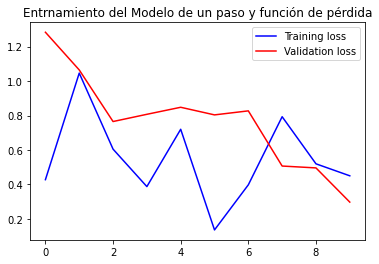

In [ ]:
plot_train_history(single_step_historyEC,
                   'Entrnamiento del Modelo de un paso y función de pérdida')

## Obtención de la predicción a un paso

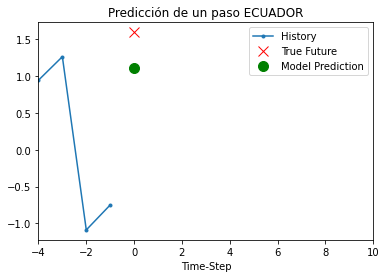

In [ ]:
for x, y in val_data_singleEC.take(1):
  plot = show_plot([x[0][:, 3].numpy(), y[0].numpy(),
                    single_step_modelEC.predict(x)[0]], 0,
                   'Predicción de un paso ECUADOR')
  plot.show()


## Graficar serie con dato predicho

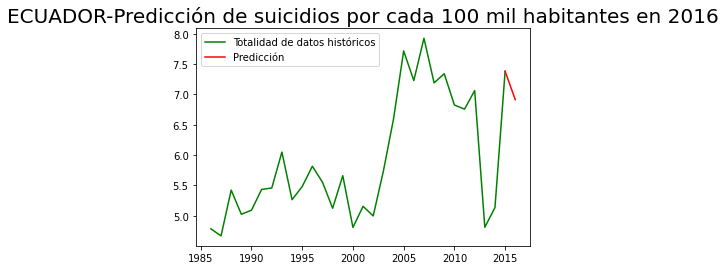

array([6.914298], dtype=float32)

In [ ]:
NEC=len(ecuador_suicides.index)-1
new_indexEC=np.append(ecuador_suicides.index, ecuador_suicides.index[NEC]+1)
new_predEC=(single_step_modelEC.predict(x)[0])*data_stdEC[3]+data_meanEC[3]
new_suicides_rateEC=np.append(ecuador_suicides['suicides/100k pop'],new_predEC)
new_dataEC=pd.DataFrame({'new_suicides_rate':new_suicides_rateEC},index=new_indexEC)
plt.plot(new_dataEC[:NEC+1], color='g', label='Totalidad de datos históricos')
plt.plot(new_dataEC[NEC:],label='Predicción',color='r')
plt.title("ECUADOR-Predicción de suicidios por cada 100 mil habitantes en 2016", size = 20)
plt.legend()
plt.show()
new_predEC

# COSTA RICA

Costa rica tiene registros desde el año 1985 al 2014. Todos los países trabajados hasta ahora se han dejado con registros desde 1986 a 2015 y se realiza la predicción de 2016.
Por esta razón se hará predicción multipaso para los años 2015 y 2016 para Costa Rica y finalmente hacer un recorte del año 1985 para que tenga el mismo tamaño de las series de los demás países.

In [ ]:
costar_suicides=data[data.country=="Costa Rica"]
costar_suicides=costar_suicides.drop(['country'],axis='columns')
#costar_suicides=costar_suicides.drop([1985],axis=0)
costar_suicides.shape
costar_suicides.head(2)

,gdp_per_capita,suicides_no,population,suicides/100k pop,female,male,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
year,,,,,,,,,,,,
1985,2145,128,2236200.0,5.723996,16,112,41,35,35,3,13,1
1986,2389,131,2292900.0,5.713289,13,118,27,28,50,2,21,3


## Gráfico de serie de interes (suicides/100k pop) y de coseries

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


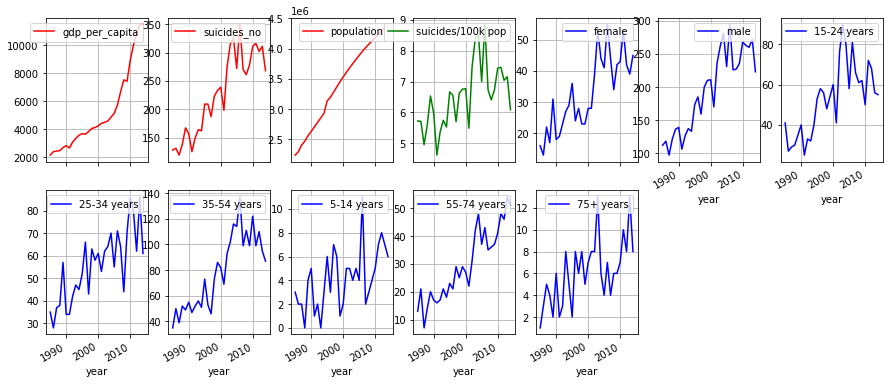

In [ ]:
featuresCR=costar_suicides
featuresCR.plot(kind='line', figsize=(15,10), subplots=True, grid=True,
    layout=(3, 7), sharex=True, sharey=False, legend=False,    
    style=['r', 'r', 'r', 'g', 'b', 'b', 'b', 'b', 'b', 'b', 'b','b','b','b','b','b','b','b'])
[ax.legend(loc=1) for ax in plt.gcf().axes]
plt.show()

## Selección de tamaño de muestra de entrenamiento y validación

In [ ]:
featuresCR=costar_suicides
train_setCR=featuresCR.iloc[:24, :]
test_setCR=featuresCR.iloc[24:30,:]
test_setCR.shape

(6, 12)

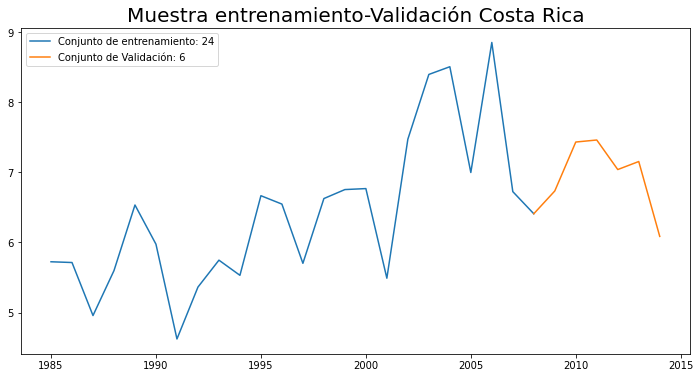

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(costar_suicides['suicides/100k pop'][0:train_setCR.shape[0]], label='Conjunto de entrenamiento: 24' )
plt.plot(costar_suicides['suicides/100k pop'][train_setCR.shape[0]-1:30], label='Conjunto de Validación: 6') 
plt.title("Muestra entrenamiento-Validación Costa Rica", size = 20)
plt.legend()
plt.show()

## Estandarización de datos

In [ ]:
TRAIN_SPLITCR=train_setCR.shape[0]
datasetCR = featuresCR.values
data_meanCR = datasetCR[:TRAIN_SPLITCR].mean(axis=0)
data_stdCR = datasetCR[:TRAIN_SPLITCR].std(axis=0)
datasetCR = (datasetCR-data_meanCR)/data_stdCR

## Selección de muestra de entrenamiento y validación para modelo **multipaso** multivariado

In [ ]:
past_history = 3
future_target = 2 # Se requiere predicción de dos años: 2015 y 2016.
STEP=1
x_train_multiCR, y_train_multiCR = multivariate_data(datasetCR, datasetCR[:, 3], 0,
                                                 TRAIN_SPLITCR, past_history,
                                                 future_target, STEP)
x_val_multiCR, y_val_multiCR = multivariate_data(datasetCR, datasetCR[:, 3],
                                             TRAIN_SPLITCR, None, past_history,
                                             future_target, STEP)

In [ ]:
print ('Single window of past history : {}'.format(x_train_multiCR[0].shape))
print ('\n Target suicides for 100kp to predict : {}'.format(y_train_multiCR[0].shape))

Single window of past history : (5, 12)

 Target suicides for 100kp to predict : (2,)


## Convertir datos en tensores

In [ ]:
BATCH_SIZE=2
BUFFER_SIZE=1000

train_data_multiCR = tf.data.Dataset.from_tensor_slices((x_train_multiCR, y_train_multiCR))
train_data_multiCR = train_data_multiCR.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multiCR = tf.data.Dataset.from_tensor_slices((x_val_multiCR, y_val_multiCR))
val_data_multiCR = val_data_multiCR.batch(BATCH_SIZE).repeat()

In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))

## Función para ventana Multipaso

In [ ]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    plt.ylim(0,2)
  plt.legend(loc='upper left')
  plt.show()

## Dos últimos años que se quieren predecir para comprobar eficiencia del modelo

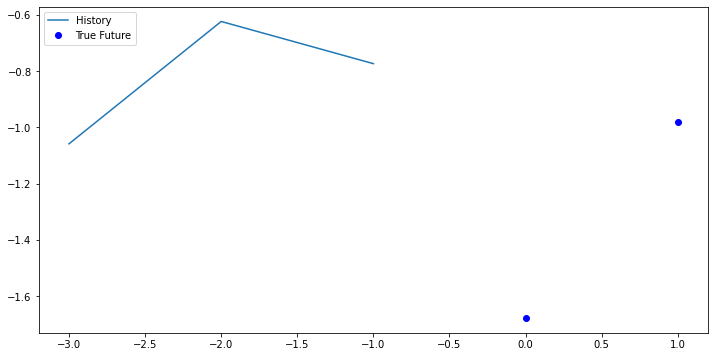

In [ ]:
for x, y in train_data_multiCR.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

## MODELO DE RED LSTM MULTIPASO

In [ ]:
multi_step_modelCR = tf.keras.models.Sequential()
multi_step_modelCR.add(tf.keras.layers.LSTM(60,
                                          return_sequences=True,
                                          input_shape=x_train_multiCR.shape[-2:]))
multi_step_modelCR.add(tf.keras.layers.LSTM(30, activation='relu'))
multi_step_modelCR.add(tf.keras.layers.Dense(2))

multi_step_modelCR.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
multi_step_modelCR.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 4, 60)             17520     
_________________________________________________________________
lstm_35 (LSTM)               (None, 30)                10920     
_________________________________________________________________
dense_33 (Dense)             (None, 2)                 62        
Total params: 28,502
Trainable params: 28,502
Non-trainable params: 0
_________________________________________________________________


## Evaluación de función de pérdida

In [ ]:
EPOCHS=100
multi_step_historyCR = multi_step_modelCR.fit(train_data_multiCR, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multiCR,
                                          validation_steps=1)

Epoch 1/100
1/1 [==============================] - 0s 464ms/step - loss: 0.8644 - val_loss: 0.6249
Epoch 2/100
1/1 [==============================] - 0s 10ms/step - loss: 0.2330 - val_loss: 0.6264
Epoch 3/100
1/1 [==============================] - 0s 8ms/step - loss: 0.5512 - val_loss: 0.6262
Epoch 4/100
1/1 [==============================] - 0s 9ms/step - loss: 0.6032 - val_loss: 0.6289
Epoch 5/100
1/1 [==============================] - 0s 9ms/step - loss: 0.7027 - val_loss: 0.6271
Epoch 6/100
1/1 [==============================] - 0s 8ms/step - loss: 1.2670 - val_loss: 0.6223
Epoch 7/100
1/1 [==============================] - 0s 8ms/step - loss: 1.1382 - val_loss: 0.6085
Epoch 8/100
1/1 [==============================] - 0s 9ms/step - loss: 0.8722 - val_loss: 0.5985
Epoch 9/100
1/1 [==============================] - 0s 8ms/step - loss: 0.9330 - val_loss: 0.5909
Epoch 10/100
1/1 [==============================] - 0s 8ms/step - loss: 0.6821 - val_loss: 0.5943
Epoch 11/100
1/1 [========

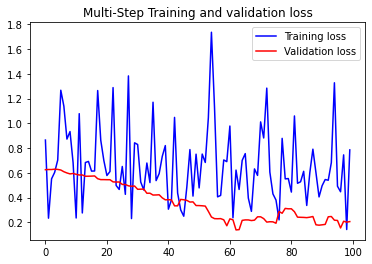

In [ ]:
plot_train_history(multi_step_historyCR, 'Multi-Step Training and validation loss')

## Obtención de predicción a dos pasos

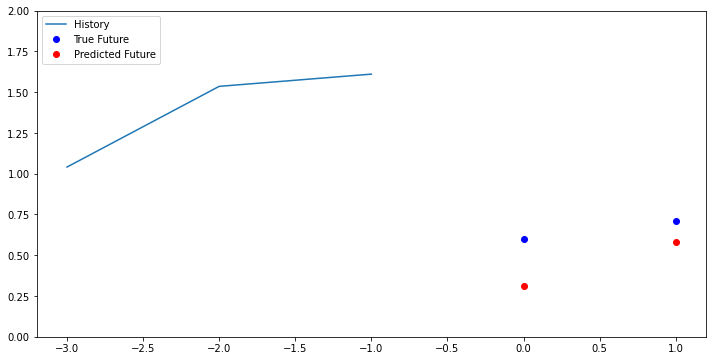

In [ ]:
for x, y in val_data_multiCR.take(1):
  multi_step_plot(x[0], y[0], multi_step_modelCR.predict(x)[0])


## Graficar serie con dato predicho

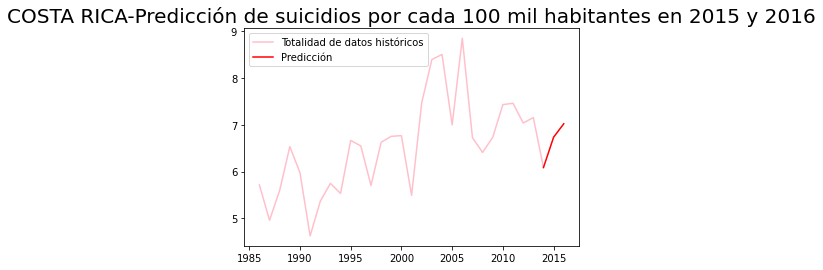

array([6.735161, 7.021875], dtype=float32)

In [ ]:
NCR=len(costar_suicides.index)-1
new_indexCR=np.append(costar_suicides.index[1:30],[costar_suicides.index[NCR]+1,costar_suicides.index[NCR]+2])
new_predCR=(multi_step_modelCR.predict(x)[0]*data_stdCR[3])+data_meanCR[3]
new_suicides_rateCR=np.append(costar_suicides['suicides/100k pop'][1:30],new_predCR)
new_dataCR=pd.DataFrame({'new_suicides_rate':new_suicides_rateCR},index=new_indexCR)
plt.plot(new_dataCR[:NCR], color='pink', label='Totalidad de datos históricos')
plt.plot(new_dataCR[NCR-1:],label='Predicción',color='r')
plt.title("COSTA RICA-Predicción de suicidios por cada 100 mil habitantes en 2015 y 2016", size = 20)
plt.legend()
plt.show()
new_predCR

# COLOMBIA

In [ ]:
colombia_suicides=data[data.country=="Colombia"]
colombia_suicides=colombia_suicides.drop(['country'],axis='columns')
colombia_suicides=colombia_suicides.drop([1985],axis=0)
colombia_suicides.shape
colombia_suicides.tail(2)

,gdp_per_capita,suicides_no,population,suicides/100k pop,female,male,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
year,,,,,,,,,,,,
2014,8591,2126,44021800.0,4.829425,371,1755,612,477,559,64,326,88
2015,6552,2332,44490427.0,5.241577,482,1850,649,490,656,83,362,92


## Gráfico de serie de interes (suicides/100k pop) y de coseries



No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


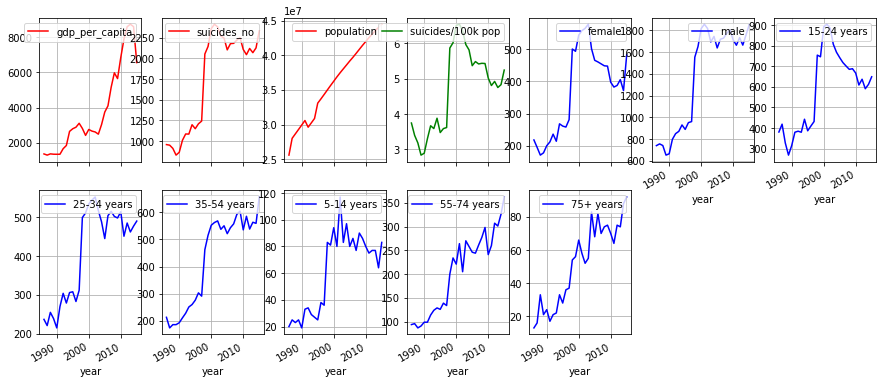

In [ ]:
featuresCO=colombia_suicides
featuresCO.plot(kind='line', figsize=(15,10), subplots=True, grid=True,
    layout=(3, 7), sharex=True, sharey=False, legend=False,    
    style=['r', 'r', 'r', 'g', 'b', 'b', 'b', 'b', 'b', 'b', 'b','b','b','b','b','b','b','b'])
[ax.legend(loc=1) for ax in plt.gcf().axes]
plt.show()

## Selección de tamaño de muestra de entrenamiento y validación

In [ ]:
featuresCO=colombia_suicides
train_setCO=featuresCO.iloc[:25, :]
test_setCO=featuresCO.iloc[25:30,:]
test_setCO.shape

(5, 12)

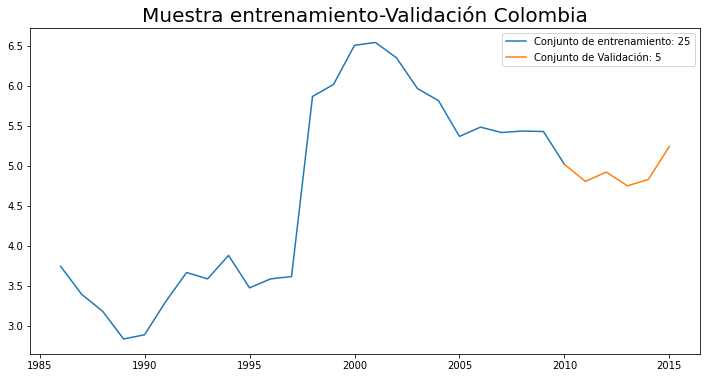

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(colombia_suicides['suicides/100k pop'][0:train_setCO.shape[0]], label='Conjunto de entrenamiento: 25' )
plt.plot(colombia_suicides['suicides/100k pop'][train_setCO.shape[0]-1:30], label='Conjunto de Validación: 5') 
plt.title("Muestra entrenamiento-Validación Colombia", size = 20)
plt.legend()
plt.show()

## Estandarización de datos

In [ ]:
TRAIN_SPLITCO=train_setCO.shape[0]
datasetCO = featuresCO.values
data_meanCO = datasetCO[:TRAIN_SPLITCO].mean(axis=0)
data_stdCO = datasetCO[:TRAIN_SPLITCO].std(axis=0)
datasetCO = (datasetCO-data_meanCO)/data_stdCO

## Selección de muestra de entrenamiento y validación

In [ ]:
past_history = 4 #se usan los últimos 4 datos para predecir a un paso.
future_target = 0 
STEP = 1
x_train_singleCO, y_train_singleCO = multivariate_data(datasetCO, datasetCO[:, 3], 0,  #la columna 3 es 'suicides/100k pop'
                                                   TRAIN_SPLITCO, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_singleCO, y_val_singleCO = multivariate_data(datasetCO, datasetCO[:, 3],
                                               TRAIN_SPLITCO, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

## Convertir datos en tensores

In [ ]:
BATCH_SIZE=2
BUFFER_SIZE=1000

train_data_singleCO = tf.data.Dataset.from_tensor_slices((x_train_singleCO, y_train_singleCO))
train_data_singleCO = train_data_singleCO.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_singleCO = tf.data.Dataset.from_tensor_slices((x_val_singleCO, y_val_singleCO))
val_data_singleCO = val_data_singleCO.batch(BATCH_SIZE).repeat()

## MODELO DE RED LSTM

In [ ]:
single_step_modelCO = tf.keras.models.Sequential()
single_step_modelCO.add(tf.keras.layers.LSTM(70,input_shape=x_train_singleCO.shape[-2:]))
single_step_modelCO.add(tf.keras.layers.Dense(1))
single_step_modelCO.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
single_step_modelCO.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 70)                23240     
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 71        
Total params: 23,311
Trainable params: 23,311
Non-trainable params: 0
_________________________________________________________________


## Evaluación de función de pérdida

In [ ]:
EPOCHS=10
EVALUATION_INTERVAL=1
single_step_historyCO = single_step_modelCO.fit(train_data_singleCO, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_singleCO,
                                            validation_steps=1)

Epoch 1/10
1/1 [==============================] - 0s 16ms/step - loss: 0.8325 - val_loss: 0.1938
Epoch 2/10
1/1 [==============================] - 0s 15ms/step - loss: 0.5980 - val_loss: 0.3024
Epoch 3/10
1/1 [==============================] - 0s 13ms/step - loss: 0.2223 - val_loss: 0.2740
Epoch 4/10
1/1 [==============================] - 0s 14ms/step - loss: 0.0972 - val_loss: 0.2240
Epoch 5/10
1/1 [==============================] - 0s 11ms/step - loss: 0.2426 - val_loss: 0.2849
Epoch 6/10
1/1 [==============================] - 0s 11ms/step - loss: 0.3924 - val_loss: 0.3067
Epoch 7/10
1/1 [==============================] - 0s 11ms/step - loss: 0.5046 - val_loss: 0.2574
Epoch 8/10
1/1 [==============================] - 0s 14ms/step - loss: 0.1873 - val_loss: 0.3103
Epoch 9/10
1/1 [==============================] - 0s 13ms/step - loss: 0.3629 - val_loss: 0.2125
Epoch 10/10
1/1 [==============================] - 0s 12ms/step - loss: 0.1268 - val_loss: 0.1743


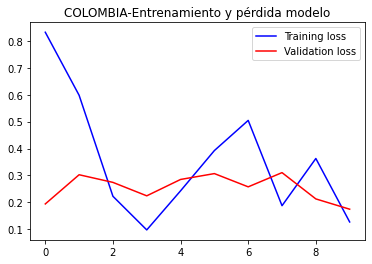

In [ ]:
plot_train_history(single_step_historyCO,
                   'COLOMBIA-Entrenamiento y pérdida modelo')

## Obtención de la predicción a un paso

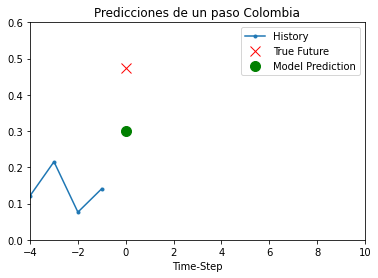

In [ ]:
for x, y in val_data_singleCO.take(1):
  plot = show_plot([x[0][:, 3].numpy(), y[0].numpy(),
                    single_step_modelCO.predict(x)[0]], 0,
                   'Predicciones de un paso Colombia')
  plot.ylim(0,0.6)
  plot.show()

## Graficar serie con dato predicho

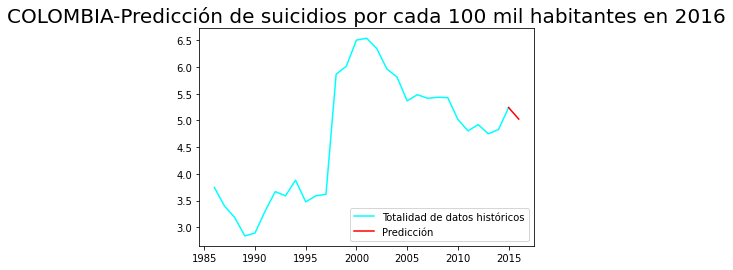

array([5.025441], dtype=float32)

In [ ]:
NCO=len(colombia_suicides.index)-1
new_indexCO=np.append(colombia_suicides.index, colombia_suicides.index[NCO]+1)
new_predCO=(single_step_modelCO.predict(x)[0])*data_stdCO[3]+data_meanCO[3]
new_suicides_rateCO=np.append(colombia_suicides['suicides/100k pop'],new_predCO)
new_dataCO=pd.DataFrame({'new_suicides_rate':new_suicides_rateCO},index=new_indexCO)
plt.plot(new_dataCO[:NCO+1], color='cyan', label='Totalidad de datos históricos')
plt.plot(new_dataCO[NCO:],label='Predicción',color='r')
plt.title("COLOMBIA-Predicción de suicidios por cada 100 mil habitantes en 2016", size = 20)
plt.legend()
plt.show()
new_predCO

# MÉXICO

In [ ]:
mexico_suicides=data[data.country=="Mexico"]
mexico_suicides=mexico_suicides.drop(['country'],axis='columns')
mexico_suicides=mexico_suicides.drop([1985],axis=0)
mexico_suicides.shape
mexico_suicides.head(5)

,gdp_per_capita,suicides_no,population,suicides/100k pop,female,male,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
year,,,,,,,,,,,,
1986,1873,1714,69123500.0,2.479620,269,1445,525,458,412,57,188,74
1987,2064,1701,67948100.0,2.503381,285,1416,518,446,446,52,181,58
1988,2630,1703,69646000.0,2.445223,280,1423,536,420,413,61,206,67
1989,3125,1865,71359000.0,2.613546,285,1580,568,433,483,54,239,88
1990,3595,1926,73076900.0,2.635580,278,1648,586,444,495,51,258,92


## Gráfico de serie de interés (suicides/100k pop) y de coseries.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


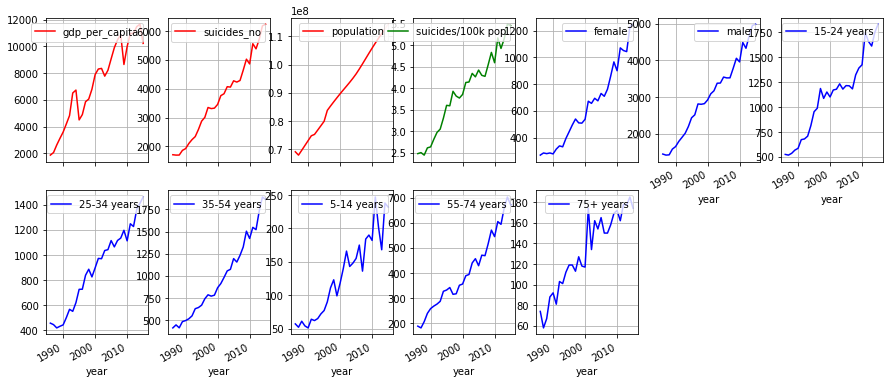

In [ ]:
featuresME=mexico_suicides
featuresME.plot(kind='line', figsize=(15,10), subplots=True, grid=True,
    layout=(3, 7), sharex=True, sharey=False, legend=False,    
    style=['r', 'r', 'r', 'g', 'b', 'b', 'b', 'b', 'b', 'b', 'b','b','b','b','b','b','b','b'])
[ax.legend(loc=1) for ax in plt.gcf().axes]
plt.show()

## Selección de tamaño de muestra de entrenamiento y validación

In [ ]:
featuresME=mexico_suicides
train_setME=featuresME.iloc[:25, :]
test_setME=featuresME.iloc[25:30,:]

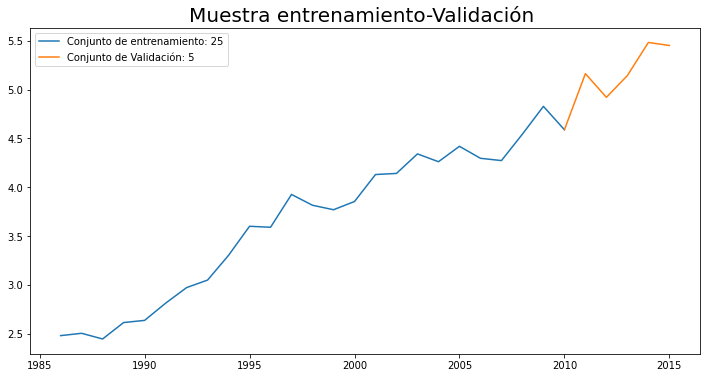

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(mexico_suicides['suicides/100k pop'][0:25], label='Conjunto de entrenamiento: 25' )
plt.plot(mexico_suicides['suicides/100k pop'][24:30], label='Conjunto de Validación: 5') 
plt.title("Muestra entrenamiento-Validación ", size = 20)
plt.legend()
plt.show()

## estandarización de datos

In [ ]:
TRAIN_SPLITME=train_setME.shape[0]
datasetME = featuresME.values
data_meanME = datasetME[:TRAIN_SPLITME].mean(axis=0)
data_stdME = datasetME[:TRAIN_SPLITME].std(axis=0)
datasetME = (datasetME-data_meanME)/data_stdME

## Selección de muestra de entrenamiento y validación

In [ ]:
past_history = 4 #se usan los últimos 4 datos para predecir a un paso.
future_target = 0 
STEP = 1
x_train_singleME, y_train_singleME = multivariate_data(datasetME, datasetME[:, 3], 0,  #la columna 3 es 'suicides/100k pop'
                                                   TRAIN_SPLITCH, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_singleME, y_val_singleME = multivariate_data(datasetME, datasetME[:, 3],
                                               TRAIN_SPLITME, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

## Convertir datos en tensores

In [ ]:
BATCH_SIZE=2
BUFFER_SIZE=1000

train_data_singleME = tf.data.Dataset.from_tensor_slices((x_train_singleME, y_train_singleME))
train_data_singleME = train_data_singleME.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_singleME = tf.data.Dataset.from_tensor_slices((x_val_singleME, y_val_singleME))
val_data_singleME = val_data_singleME.batch(BATCH_SIZE).repeat()

## MODELO DE RED LSTM

In [ ]:
single_step_modelME = tf.keras.models.Sequential()
single_step_modelME.add(tf.keras.layers.LSTM(70,input_shape=x_train_singleME.shape[-2:]))
single_step_modelME.add(tf.keras.layers.Dense(1))
single_step_modelME.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
single_step_modelME.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 70)                23240     
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 71        
Total params: 23,311
Trainable params: 23,311
Non-trainable params: 0
_________________________________________________________________


## Evaluación de función de pérdida

In [ ]:
EPOCHS=20
EVALUATION_INTERVAL=1
single_step_historyME = single_step_modelME.fit(train_data_singleME, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_singleME,
                                            validation_steps=1)

Epoch 1/20
1/1 [==============================] - 0s 363ms/step - loss: 1.3494 - val_loss: 3.3104
Epoch 2/20
1/1 [==============================] - 0s 9ms/step - loss: 1.3326 - val_loss: 3.1185
Epoch 3/20
1/1 [==============================] - 0s 8ms/step - loss: 0.4037 - val_loss: 3.0014
Epoch 4/20
1/1 [==============================] - 0s 7ms/step - loss: 0.5101 - val_loss: 3.0219
Epoch 5/20
1/1 [==============================] - 0s 8ms/step - loss: 0.3738 - val_loss: 3.1116
Epoch 6/20
1/1 [==============================] - 0s 8ms/step - loss: 0.3024 - val_loss: 3.0978
Epoch 7/20
1/1 [==============================] - 0s 8ms/step - loss: 1.0291 - val_loss: 2.7623
Epoch 8/20
1/1 [==============================] - 0s 8ms/step - loss: 0.5225 - val_loss: 2.5956
Epoch 9/20
1/1 [==============================] - 0s 9ms/step - loss: 0.9511 - val_loss: 2.1446
Epoch 10/20
1/1 [==============================] - 0s 8ms/step - loss: 0.8739 - val_loss: 1.6819
Epoch 11/20
1/1 [====================

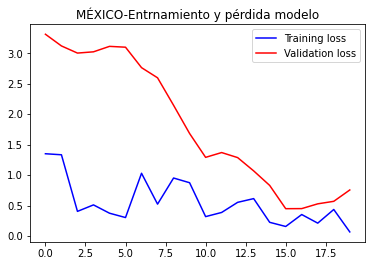

In [ ]:
plot_train_history(single_step_historyME,
                   'MÉXICO-Entrnamiento y pérdida modelo')

## Obtención de la predicción a un paso

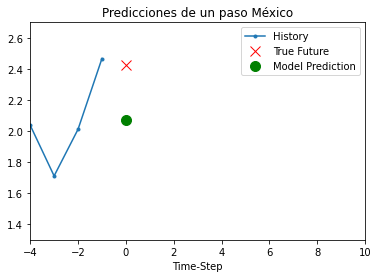

In [ ]:
for x, y in val_data_singleME.take(1):
  plot = show_plot([x[0][:, 3].numpy(), y[0].numpy(),
                    single_step_modelME.predict(x)[0]], 0,
                   'Predicciones de un paso México')
  plot.ylim(1.3,2.7)
  plot.show()

## Graficar serie con dato predicho

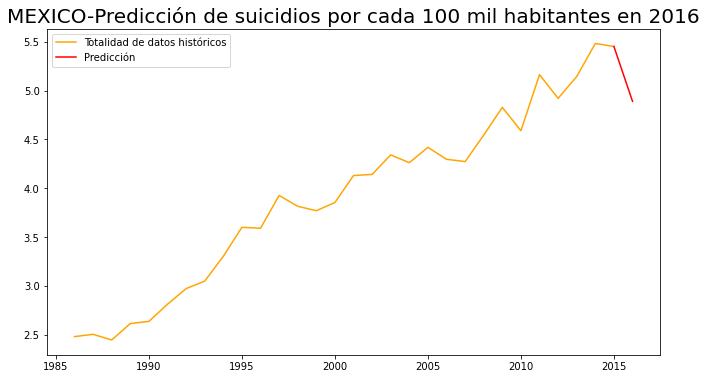

array([4.8896847], dtype=float32)

In [ ]:
plt.figure(figsize=(11,6))
NME=len(mexico_suicides.index)-1
new_indexME=np.append(mexico_suicides.index, mexico_suicides.index[NME]+1)
new_predME=(single_step_modelME.predict(x)[0])*data_stdME[3]+data_meanME[3] 
new_suicides_rateME=np.append(mexico_suicides['suicides/100k pop'],new_predME)
new_dataME=pd.DataFrame({'new_suicides_rate':new_suicides_rateME},index=new_indexME)
plt.plot(new_dataME[:NME+1], color='orange', label='Totalidad de datos históricos')
plt.plot(new_dataME[NME:],label='Predicción',color='r')
plt.title("MEXICO-Predicción de suicidios por cada 100 mil habitantes en 2016", size = 20)
plt.legend()
plt.show()
new_predME

# ARGENTINA

In [ ]:
argentina_suicides=data[data.country=="Argentina"]
argentina_suicides=argentina_suicides.drop(['country'],axis='columns')
argentina_suicides=argentina_suicides.drop([1985],axis=0)
argentina_suicides.shape
argentina_suicides.head(2)

,gdp_per_capita,suicides_no,population,suicides/100k pop,female,male,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
year,,,,,,,,,,,,
1986,4072,2284,27244400.0,8.383374,641,1643,287,305,666,17,731,278
1987,4026,2286,27599400.0,8.282789,686,1600,272,281,691,29,756,257


## Gráfico de serie de interés (suicides/100k pop) y de coseries.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


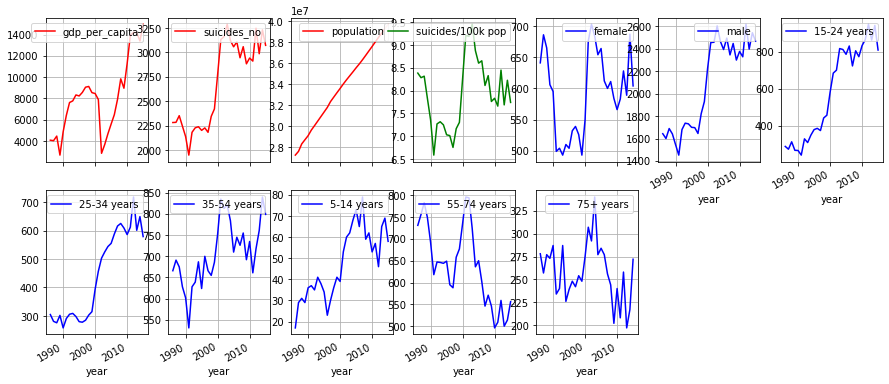

In [ ]:
featuresAR=argentina_suicides
featuresAR.plot(kind='line', figsize=(15,10), subplots=True, grid=True,
    layout=(3, 7), sharex=True, sharey=False, legend=False,    
    style=['r', 'r', 'r', 'g', 'b', 'b', 'b', 'b', 'b', 'b', 'b','b','b','b','b','b','b','b'])
[ax.legend(loc=1) for ax in plt.gcf().axes]
plt.show()

## Selección de tamaño de muestra de entrenamiento y validación.

In [ ]:
featuresAR=argentina_suicides
train_setAR=featuresAR.iloc[:25, :]
test_setAR=featuresAR.iloc[25:30,:]
test_setAR.shape

(5, 12)

## Estandarización de datos.

In [ ]:
TRAIN_SPLITAR=train_setAR.shape[0]
datasetAR = featuresAR.values
data_meanAR = datasetAR[:TRAIN_SPLITAR].mean(axis=0)
data_stdAR = datasetAR[:TRAIN_SPLITAR].std(axis=0)
datasetAR = (datasetAR-data_meanAR)/data_stdAR

## Selección de muestra de entrenamiento y validación

In [ ]:
past_history = 4 #se usan los últimos 4 datos para predecir a un paso.
future_target = 0 
STEP = 1
x_train_singleAR, y_train_singleAR = multivariate_data(datasetAR, datasetAR[:, 3], 0,  #la columna 3 es 'suicides/100k pop'
                                                   TRAIN_SPLITAR, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_singleAR, y_val_singleAR = multivariate_data(datasetAR, datasetAR[:, 3],
                                               TRAIN_SPLITAR, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

## Convertir datos en tensores

In [ ]:
BATCH_SIZE=2
BUFFER_SIZE=1000

train_data_singleAR = tf.data.Dataset.from_tensor_slices((x_train_singleAR, y_train_singleAR))
train_data_singleAR = train_data_singleAR.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_singleAR = tf.data.Dataset.from_tensor_slices((x_val_singleAR, y_val_singleAR))
val_data_singleAR = val_data_singleAR.batch(BATCH_SIZE).repeat()

## MODELO DE RED LSTM

In [ ]:
single_step_modelAR = tf.keras.models.Sequential()
single_step_modelAR.add(tf.keras.layers.LSTM(70,input_shape=x_train_singleAR.shape[-2:]))
single_step_modelAR.add(tf.keras.layers.Dense(1))
single_step_modelAR.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
single_step_modelAR.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 70)                23240     
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 71        
Total params: 23,311
Trainable params: 23,311
Non-trainable params: 0
_________________________________________________________________


## Evaluación de función de pérdida

In [ ]:
EPOCHS=10
EVALUATION_INTERVAL=1
single_step_historyAR = single_step_modelAR.fit(train_data_singleAR, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_singleAR,
                                            validation_steps=1)

Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.4867 - val_loss: 0.2342
Epoch 2/10
1/1 [==============================] - 0s 12ms/step - loss: 0.2832 - val_loss: 0.2619
Epoch 3/10
1/1 [==============================] - 0s 14ms/step - loss: 0.2410 - val_loss: 0.2025
Epoch 4/10
1/1 [==============================] - 0s 11ms/step - loss: 0.2180 - val_loss: 0.2506
Epoch 5/10
1/1 [==============================] - 0s 11ms/step - loss: 0.2415 - val_loss: 0.1168
Epoch 6/10
1/1 [==============================] - 0s 10ms/step - loss: 0.1084 - val_loss: 0.2120
Epoch 7/10
1/1 [==============================] - 0s 10ms/step - loss: 0.1445 - val_loss: 0.2163
Epoch 8/10
1/1 [==============================] - 0s 11ms/step - loss: 0.2859 - val_loss: 0.1667
Epoch 9/10
1/1 [==============================] - 0s 10ms/step - loss: 0.3437 - val_loss: 0.1725
Epoch 10/10
1/1 [==============================] - 0s 10ms/step - loss: 0.2519 - val_loss: 0.3157


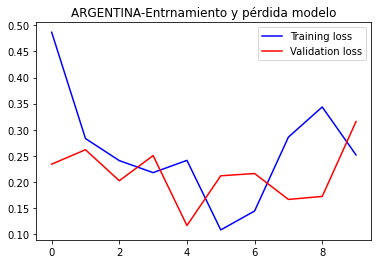

In [ ]:
plot_train_history(single_step_historyAR,
                   'ARGENTINA-Entrnamiento y pérdida modelo')

## Obtención de predicción a un paso.

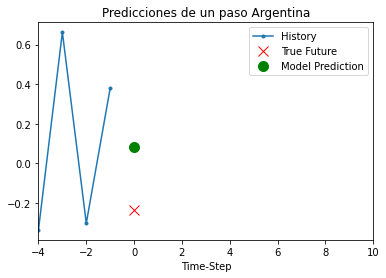

In [ ]:
for x, y in val_data_singleAR.take(1):
  plot = show_plot([x[0][:, 3].numpy(), y[0].numpy(),
                    single_step_modelAR.predict(x)[0]], 0,
                   'Predicciones de un paso Argentina')
  plot.show()

## Graficar dato predicho.

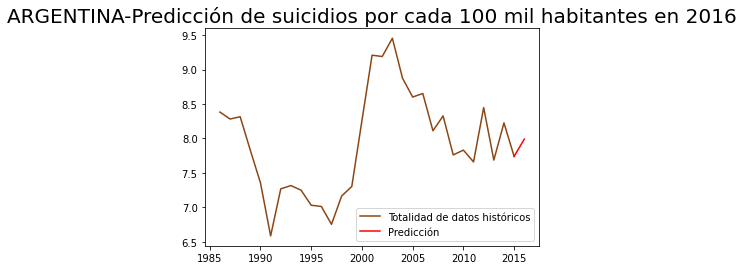

array([7.9905305], dtype=float32)

In [ ]:
NAR=len(argentina_suicides.index)-1
new_indexAR=np.append(argentina_suicides.index, argentina_suicides.index[NAR]+1)
new_predAR=(single_step_modelAR.predict(x)[0])*data_stdAR[3]+data_meanAR[3]
new_suicides_rateAR=np.append(argentina_suicides['suicides/100k pop'],new_predAR)
new_dataAR=pd.DataFrame({'new_suicides_rate':new_suicides_rateAR},index=new_index)
plt.plot(new_dataAR[:NAR+1], color='saddlebrown', label='Totalidad de datos históricos')
plt.plot(new_dataAR[NAR:],label='Predicción',color='r')
plt.title("ARGENTINA-Predicción de suicidios por cada 100 mil habitantes en 2016", size = 20)
plt.legend()
plt.show()
new_predAR

**# GRÁFICO DE PREDICCIONES PARA TODOS LOS PAÍSES LATINOAMERICANOS DEL ESTUDIO.**

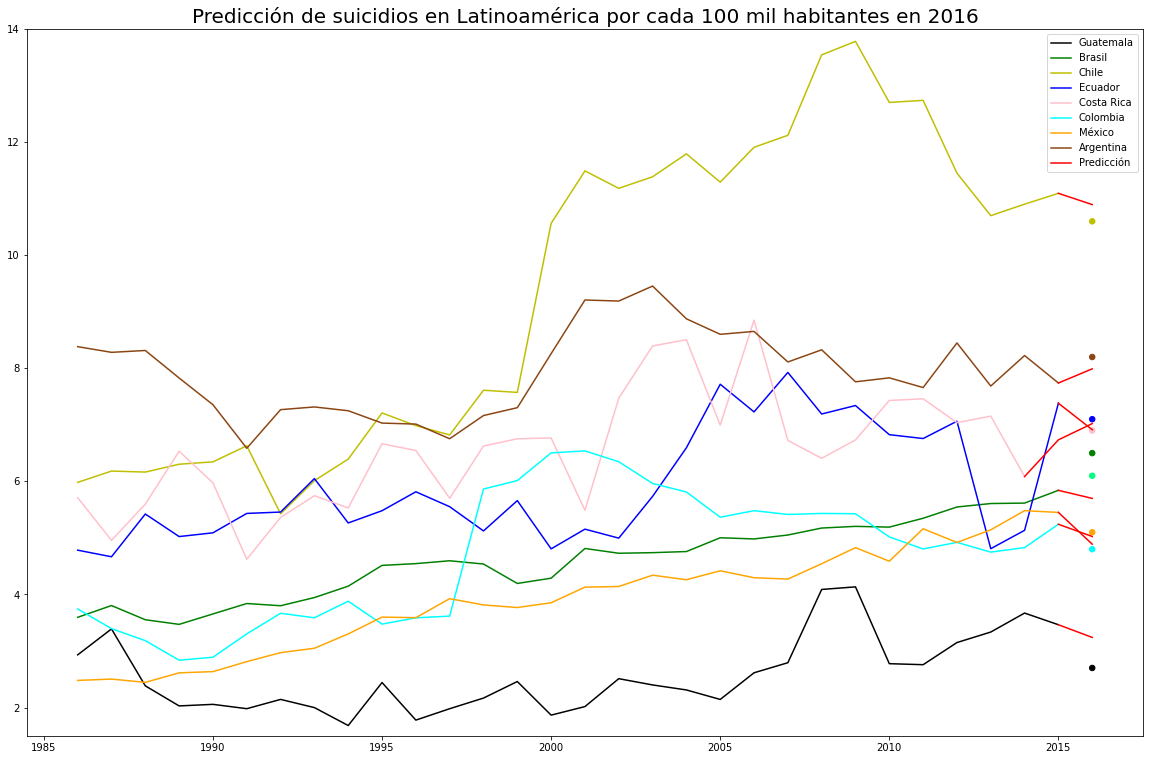

In [ ]:
plt.figure(figsize=(20,13))
plt.plot(new_dataGU[:NGU+1], color='black', label='Guatemala')
plt.plot(new_dataGU[NGU:],color='r')
plt.plot(new_dataBR[:NBR+1], color='g', label='Brasil')
plt.plot(new_dataBR[NBR:],color='r')
plt.plot(new_dataCH[:NCH+1], color='y', label='Chile')
plt.plot(new_dataCH[NCH:],color='r')
plt.plot(new_dataEC[:NEC+1], color='b', label='Ecuador')
plt.plot(new_dataEC[NEC:],color='r')
plt.plot(new_dataCR[:NCR], color='pink', label='Costa Rica')
plt.plot(new_dataCR[NCR-1:],color='r')
plt.plot(new_dataCO[:NCO+1], color='cyan', label='Colombia')
plt.plot(new_dataCO[NCO:],color='r')
plt.plot(new_dataME[:NME+1], color='orange', label='México')
plt.plot(new_dataME[NME:],color='r')
plt.plot(new_dataAR[:NAR+1], color='saddlebrown', label='Argentina')
plt.plot(new_dataAR[NAR:],label='Predicción',color='r')


x_number_list = np.repeat(2016, 9)
y_number_list = [2.7, 6.5, 10.6, 7.1, 6.9, 4.8, 5.1, 8.2]
plt.scatter(x_number_list, y_number_list, s=30, c=['black','g','y','b','pink','cyan','orange','saddlebrown'])
plt.ylim(1.5,14)
plt.title("Predicción de suicidios en Latinoamérica por cada 100 mil habitantes en 2016", size = 20)
plt.legend()
plt.show()